In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from sklearn.preprocessing import MinMaxScaler

import prepare
import acquire
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = acquire.acquire_zillow()
df = prepare.clean_zillow(df)
df = prepare.focused_zillow(df)
train, validate, test = prepare.split_focused_zillow(df)

In [4]:
X_train = train.drop(columns = ['appraised_value'])
y_train = train.appraised_value

X_validate = validate.drop(columns=['appraised_value'])
y_validate = validate.appraised_value

X_test = test.drop(columns=['appraised_value'])
y_test = test.appraised_value


In [5]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [6]:
y_train

,appraised_value
31538,292000.0
5911,97093.0
20091,80091.0
36157,34746.0
1799,177000.0
...,...
9333,533508.0
33620,179483.0
10204,44689.0
37283,443829.0


In [7]:
home_value_baseline_median = y_train['appraised_value'].median()
y_train['appraised_value_pred_median'] = round(home_value_baseline_median, 2)
y_validate['appraised_value_pred_median'] = round(home_value_baseline_median, 2)

In [8]:
home_value_baseline_mean = y_train['appraised_value'].mean()
y_train['appraised_value_pred_mean'] = round(home_value_baseline_mean, 2)
y_validate['appraised_value_pred_mean'] = round(home_value_baseline_mean,2)

In [9]:
y_train

,appraised_value,appraised_value_pred_median,appraised_value_pred_mean
31538,292000.0,329107.0,364215.53
5911,97093.0,329107.0,364215.53
20091,80091.0,329107.0,364215.53
36157,34746.0,329107.0,364215.53
1799,177000.0,329107.0,364215.53
...,...,...,...
9333,533508.0,329107.0,364215.53
33620,179483.0,329107.0,364215.53
10204,44689.0,329107.0,364215.53
37283,443829.0,329107.0,364215.53


Takeaways:
- Baseline median is the way to go
    - it is less

In [10]:
# generate parameters, i.e. create model
ols_model = ols('appraised_value ~ bedrooms', data=train).fit()
    #finding the model
# compute predictions and add to original dataframe
train['yhat'] = round(ols_model.predict(train), 2)

In [11]:
#baseline is mean of dependent variable
train['baseline'] = train.appraised_value.mean()
train['residual'] = train.appraised_value - train.yhat
train['baseline_residual'] = train.appraised_value - train.baseline
train.head()

,square_feet,bedrooms,bathrooms,appraised_value,yhat,baseline,residual,baseline_residual
31538,1050.0,2.0,1.0,292000.0,323737.08,364215.525764,-31737.08,-72215.525764
5911,715.0,1.0,1.0,97093.0,274750.59,364215.525764,-177657.59,-267122.525764
20091,2097.0,2.0,2.0,80091.0,323737.08,364215.525764,-243646.08,-284124.525764
36157,1216.0,3.0,1.0,34746.0,372723.58,364215.525764,-337977.58,-329469.525764
1799,1523.0,3.0,3.0,177000.0,372723.58,364215.525764,-195723.58,-187215.525764


# Sum of Square Erros (SSE)

In [12]:
# create 2 new columns onto df
train['residual_sqr'] = train.residual ** 2
train['baseline_residual_sqr'] =  train.baseline_residual ** 2

# add all of them
SSE = train['residual_sqr'].sum()
SSE_baseline =  train['baseline_residual_sqr'].sum()

print("SSE = ", round(SSE,3))
print("SSE Baseline = ", round(SSE_baseline, 3))

SSE =  911614726222345.5
SSE Baseline =  941263447006771.6


# Mean Squared Error (MSE)

In [13]:
MSE = SSE / len(df)
MSE_baseline = SSE_baseline / len(df)

print("MSE = ", round(MSE,3))
print("MSE baseline = ", round(MSE_baseline,3))

MSE =  28013481845.687
MSE baseline =  28924572767.709


# Root Mean Squared Error (RMSE)

In [14]:
RMSE = sqrt(MSE)
RMSE_baseline = sqrt(MSE_baseline)

print("RMSE = ", round(RMSE,3))
print("RMSE baseline = ", round(RMSE_baseline,3))

RMSE =  167372.285
RMSE baseline =  170072.257


In [15]:
print("SSE Baseline = ", round(SSE_baseline, 3))
print("MSE baseline = ", round(MSE_baseline,3))
print("RMSE baseline = ", round(RMSE_baseline,3))

SSE Baseline =  941263447006771.6
MSE baseline =  28924572767.709
RMSE baseline =  170072.257


## will continue the RMSE 

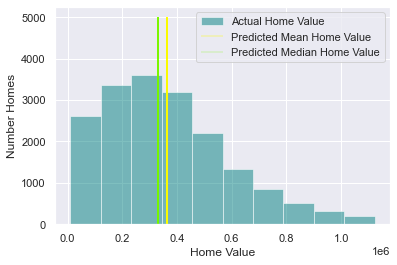

In [16]:
# plot to visualize actual vs predicted. 
sns.set(style="darkgrid")
plt.hist(y_train.appraised_value, color='teal', alpha=.5, label="Actual Home Value")
plt.vlines(y_train.appraised_value_pred_mean, 0, 5000, color='yellow', alpha=.3, label="Predicted Mean Home Value")
plt.vlines(y_train.appraised_value_pred_median, 0, 5000, color='lawngreen', alpha=.2, label="Predicted Median Home Value")
plt.xlabel("Home Value")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

In [60]:
import evaluate

SSE =  911614726222345.5
SSE Baseline =  941263447006771.6
------------------------------------------
MSE =  28013481845.687
MSE baseline =  28924572767.709
------------------------------------------
RMSE =  167372.285
RMSE baseline =  170072.257
------------------------------------------


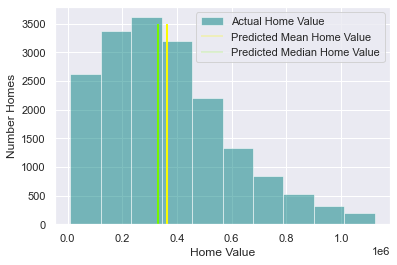

In [61]:
def SSE_MSE_RMSE_info():
    'Finds the SSE, MSE, and RMSE from add_to_train'
    df = acquire.acquire_zillow()
    df = prepare.clean_zillow(df)
    df = prepare.focused_zillow(df)
    train, validate, test = prepare.split_focused_zillow(df)
    # pull from add to trian
    train = evaluate.add_to_train()
    # set up for SSE
    train['residual_sqr'] = train.residual ** 2
    train['baseline_residual_sqr'] =  train.baseline_residual ** 2
    SSE = train['residual_sqr'].sum()
    SSE_baseline =  train['baseline_residual_sqr'].sum()
    print("SSE = ", round(SSE,3))
    print("SSE Baseline = ", round(SSE_baseline, 3))
    print('------------------------------------------')
    # set up for MSE
    MSE = SSE / len(df)
    MSE_baseline = SSE_baseline / len(df)
    print("MSE = ", round(MSE,3))
    print("MSE baseline = ", round(MSE_baseline,3))
    print('------------------------------------------')
    # set up for RMSE
    RMSE = sqrt(MSE)
    RMSE_baseline = sqrt(MSE_baseline)
    print("RMSE = ", round(RMSE,3))
    print("RMSE baseline = ", round(RMSE_baseline,3))
    print('------------------------------------------')
    # plot to visualize actual vs predicted. 
    sns.set(style="darkgrid")
    plt.hist(y_train.appraised_value, color='teal', alpha=.5, label="Actual Home Value")
    plt.vlines(y_train.appraised_value_pred_mean, 0, 3500, color='yellow', alpha=.3, label="Predicted Mean Home Value")
    plt.vlines(y_train.appraised_value_pred_median, 0, 3500, color='lawngreen', alpha=.2, label="Predicted Median Home Value")
    plt.xlabel("Home Value")
    plt.ylabel("Number Homes")
    plt.legend()
    plt.show()
    
SSE_MSE_RMSE_info()